In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np 
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "########",
                            database = "ecommerce_project")

cur = db.cursor()


# Count all unique cities where customers are located.

In [16]:
query = """select count(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
print(f'The total number of unique cities are {data[0][0]}')

The total number of unique cities are 99441


# Count the number of orders placed in 2017.

In [18]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
print(f'Count of the number of orders placed in 2017 are {data[0][0]}')

Count of the number of orders placed in 2017 are 45101


# Find the total sales per category.

In [29]:
query = """ SELECT products.product_category, round(SUM(order_items.price + order_items.freight_value),2) AS sales
FROM order_items
JOIN products ON order_items.product_id = products.product_id
GROUP BY products.product_category; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["product_category", "sales"])
df

,product_category,sales
0,HEALTH BEAUTY,1441248.07
1,sport leisure,1156656.48
2,Cool Stuff,719329.95
3,computer accessories,1059272.40
4,Watches present,1305541.61
...,...,...
68,flowers,1598.91
69,Kitchen portable and food coach,4278.29
70,House Comfort 2,1170.58
71,CITTE AND UPHACK FURNITURE,5998.54


# Calculate the percentage of orders that were paid in installments.

In [33]:
query = """ select (SELECT COUNT(payment_installments) from payments where payment_installments > 1)/COUNT(ORDER_ID)*100 
AS PERCENTAGE FROM PAYMENTS;
 """
cur.execute(query)
data = cur.fetchall()
print(f'the percentage of installments orders is {data[0][0]} percent')

the percentage of installments orders is 49.4176 percent


# Count the number of customers from each state. 

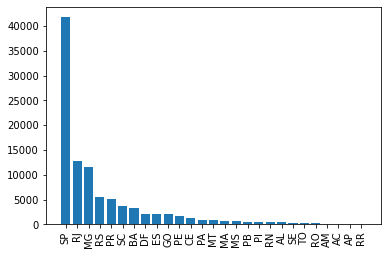

In [13]:
query = """ 
select count(*) as countt, customer_state from customers group by customer_state order by countt desc ;"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns = ["Total_Customers", "City"])
df
plt.bar(df['City'], df["Total_Customers"])
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

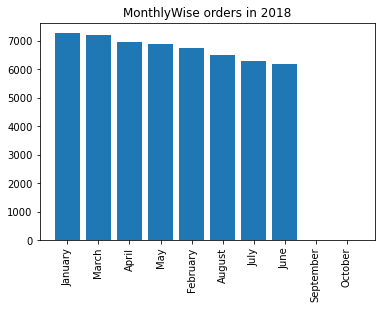

In [13]:
query = """ 

select count(*) as orders_count, monthname(order_purchase_timestamp) 
as months from orders where year(order_purchase_timestamp) = 2018
 group by months order by orders_count desc;
 
 """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns = ["total_orders", "month"])
df
plt.bar(df["month"],df["total_orders"])
plt.xticks(rotation = 90)
plt.title("MonthlyWise orders in 2018")
plt.show()

# Calculate the percentage of total revenue contributed by each product category.

In [22]:
 query = """ 


select product_category, (sum(revenue)/(select sum(revenue)from prodcut_revenue)) *100 from prodcut_revenue 
group by product_category;
 
 """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["product_category", "average"])
df

,product_category,average
0,HEALTH BEAUTY,9.218744
1,sport leisure,7.398393
2,Cool Stuff,4.601095
3,computer accessories,6.775490
4,Watches present,8.350717
...,...,...
68,flowers,0.010227
69,Kitchen portable and food coach,0.027365
70,House Comfort 2,0.007487
71,CITTE AND UPHACK FURNITURE,0.038369


# Identify the correlation between product price and the number of times a product has been purchased.

In [30]:
 query = """ 

select products.product_category, count(order_items.product_id) as total_orders, round(avg(order_items.price),2) as price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
 
 """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["product_category","total_orders", "price"])
df
np.corrcoef([df["total_orders"], df["price"]])

# No relation between orders and price 

array([[ 1.        , -0.10628612],
       [-0.10628612,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

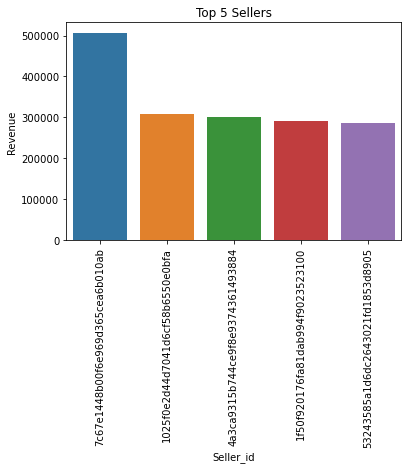

In [12]:
 query = """ 


select *, dense_rank()over(order by revenue desc) as rankk from 
(select order_items.seller_id, round(sum(payments.payment_value),2) as revenue from order_items join payments 
on order_items.order_id = payments.order_id
group by order_items.seller_id) as t;
 
 """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns = ["Seller_id","Revenue","Rank"])
dframe = df.head()

sns.barplot(x = 'Seller_id', y = 'Revenue', data = dframe)
plt.xticks(rotation = 90)
plt.title('Top 5 Sellers')
plt.show()


# Calculate the moving average of order values for each customer over their order history.

In [16]:
 query = """ 


select customer_id, order_purchase_timestamp, avg(payment_value) over( partition by customer_id order by order_purchase_timestamp 
rows between 1 preceding and current row) as mov_avg from
(select orders.customer_id, orders.order_purchase_timestamp,  payments.payment_value from orders join payments
on orders.order_id = payments.order_id) as a
 
 """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["customer_id","date","moving_avg"])
df

,customer_id,date,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,40.36
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50
